In [1]:
# dependencies
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import string
import re
import unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
%matplotlib inline

In [2]:
# notebook configurations
plt.rcParams['figure.figsize'] = 16,9
pd.set_option('display.float_format', lambda x: '%.4f' % x)
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 9999)
sns.set()

# Overview
The goal of the Fake News Challenge is to explore how artificial intelligence technologies, particularly machine learning and natural language processing, might be leveraged to combat the fake news problem. We believe that these AI technologies hold promise for significantly automating parts of the procedure human fact checkers use today to determine if a story is real or a hoax.

Assessing the veracity of a news story is a complex and cumbersome task, even for trained experts 3. Fortunately, the process can be broken down into steps or stages. A helpful first step towards identifying fake news is to understand what other news organizations are saying about the topic. We believe automating this process, called Stance Detection, could serve as a useful building block in an AI-assisted fact-checking pipeline. So stage 1 of the Fake News Challenge (FNC-1) focuses on the task of Stance Detection.

Stance Detection involves estimating the relative perspective (or stance) of two pieces of text relative to a topic, claim or issue. The version of Stance Detection we have selected for FNC-1 extends the work of Ferreira & Vlachos 4. For FNC-1 we have chosen the task of estimating the stance of a body text from a news article relative to a headline. Specifically, the body text may agree, disagree, discuss or be unrelated to the headline.

# Formal definition

```
Input
    A headline and a body text - either from the same news article or from two different articles.
Output
    Classify the stance of the body text relative to the claim made in the headline into one of four categories:
        Agrees: The body text agrees with the headline.
        Disagrees: The body text disagrees with the headline.
        Discusses: The body text discuss the same topic as the headline, but does not take a position
        Unrelated: The body text discusses a different topic than the headline
```

In [3]:
# Load data
df_train_bodies = pd.read_csv('train_bodies.csv')
df_train_stances = pd.read_csv('train_stances.csv')

In [4]:
# look at data
df_train_bodies.head()

,Body ID,articleBody
0,0,"A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. \n\nGovernment spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a ""relatively small"" meteorite that ""appears to have come off an asteroid that was passing close to Earth."" House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. \nMurillo said Nicaragua will ask international experts to help local scientists in understanding what happened.\n\nThe crater left by the meteorite had a radius of 39 feet and a depth of 16 feet, said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the committee. He said it is still not clear if the meteorite disintegrated or was buried.\n\nHumberto Garcia, of the Astronomy Center at the National Autonomous University of Nicaragua, said the meteorite could be related to an asteroid that was forecast to pass by the planet Saturday night.\n\n""We have to study it more because it could be ice or rock,"" he said.\n\nWilfried Strauch, an adviser to the Institute of Territorial Studies, said it was ""very strange that no one reported a streak of light. We have to ask if anyone has a photo or something.""\n\nLocal residents reported hearing a loud boom Saturday night, but said they didn't see anything strange in the sky.\n\n""I was sitting on my porch and I saw nothing, then all of a sudden I heard a large blast. We thought it was a bomb because we felt an expansive wave,"" Jorge Santamaria told The Associated Press.\n\nThe site of the crater is near Managua's international airport and an air force base. Only journalists from state media were allowed to visit it."
1,4,"Last week we hinted at what was to come as Ebola fears spread across America. Today, we get confirmation. As The Daily Caller reports, one passenger at Dulles International Airport outside Washington, D.C. is apparently not taking any chances. A female passenger dressed in a hazmat suit - complete with a full body gown, mask and gloves - was spotted Wednesday waiting for a flight at the airport.\n\n \n\n\n\nSource: The Daily Caller\n\nWe particularly liked the JCPenney bag - maybe that's a new business line for the bankrupt retailer...\n\n* * *\n\nOn a side note, try Halloween stores if you need a Haz-Mat suit in a hurry..."
2,5,"(NEWSER) – Wonder how long a Quarter Pounder with cheese can last? Two Australians say they bought a few McDonald's burgers for friends back in 1995, when they were teens, and one of the friends never showed up. So the kid's burger went uneaten—and stayed that way, Australia's News Network reports. ""We’re pretty sure it’s the oldest burger in the world,"" says one of the men, Casey Dean. Holding onto the burger for their friend ""started off as a joke,"" he adds, but ""the months became years and now, 20 years later, it looks the same as it did the day we bought it, perfectly preserved in its original wrapping.""\n\nDean and his burger-buying mate, Eduard Nitz, even took the burger on Australian TV show The Project last night and ""showed off the mold-free specimen,"" News 9 reports. The pair offered to take a bite of it for charity but were dissuaded by the show's hosts. They've also started a Facebook page for the burger called ""Can This 20 Year Old Burger Get More Likes Than Kanye West?"" that has more than 4,044 likes as of this writing. And they're selling an iTunes song, ""Free the Burger,"" for $1.69, and giving proceeds to the charity Beyond Blue, which helps Australians battle anxiety and depression. (A few years ago, a man sold a 20-year-old bottle of McDonald's McJordan sauce for $10,000. Here's why Mickey D's food seemingly never decays.)"
3,6,"Posting photos of a 

In [5]:
# look at stances and headlines
df_train_stances.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodies' near Mexico town where 43 students disappeared after police clash,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza as Israel opens dams,158,agree
2,"Christian Bale passes on role of Steve Jobs, actor reportedly felt he wasn't right for part",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV Streaming Service Launching in April,1034,unrelated
4,Spider burrowed through tourist's stomach and up into his chest,1923,disagree


In [6]:
# data shape
df_train_stances.shape,df_train_bodies.shape

((49972, 3), (1683, 2))

# how many times does a headline map to a body id?

Starting by looking at the data. Let's look at the stances. There are about 30x more headlines than there are article bodies. How do headlines relate to the body id?

On average there are ~30 headlines to one article body though the distribution of this varies wildly. 50% of the data is located between 8 headlines to 1 body and 42 headlines to 1 body.

count   1683.0000
mean      29.6922
std       28.7058
min        1.0000
25%        8.0000
50%       21.0000
75%       42.5000
max      187.0000
dtype: float64

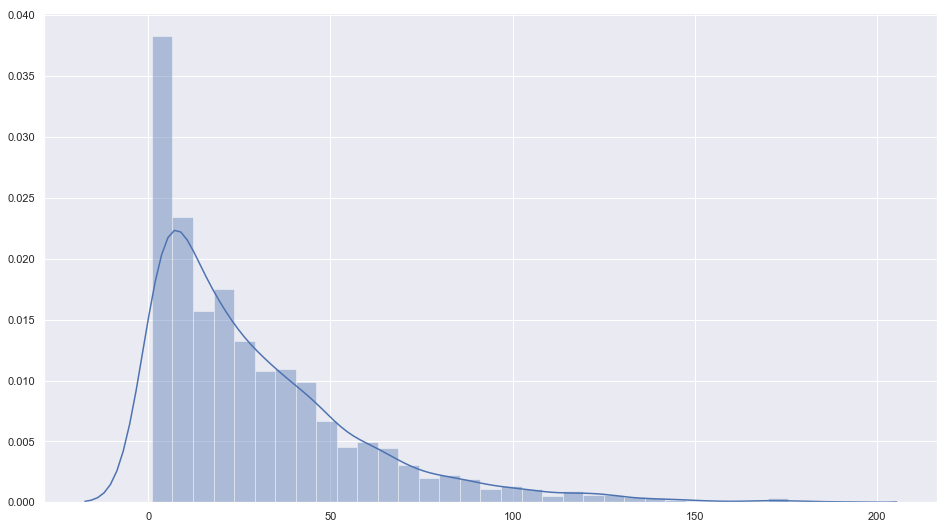

In [7]:
# looking at headline to body ratio
sns.distplot(df_train_stances.groupby('Body ID').size())
df_train_stances.groupby('Body ID').size().describe()

## What do our classes look like?

Let's look at the stance class field. The first part of the problem is to classify something as related or unrelated. Of the 49,972 labeled training examples we have, 73% of them are unrelated. This is a largely imbalanced class problem

In [8]:
df_train_stances.Stance.value_counts()

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

## How do classes relate to the body IDs?

On average, body_ids have a median of 3 headlines that agree with a body text, 2 headlines that disagree with a body text, 4 headlines that discuss the article body text, and 27 headlines that are not related to the article body text.

In [9]:
df_train_stances.groupby('Body ID')['Stance'].value_counts().unstack().describe()

Stance,agree,disagree,discuss,unrelated
count,829.0000,291.0000,1293.0000,1057.0000
mean,4.4367,2.8866,6.8902,34.5743
std,3.4780,2.6309,7.2967,27.7918
min,1.0000,1.0000,1.0000,1.0000
25%,2.0000,1.0000,2.0000,14.0000
50%,3.0000,2.0000,4.0000,27.0000
75%,6.0000,4.0000,9.0000,46.0000
max,24.0000,14.0000,49.0000,175.0000


There are 1 to 1 headline to article body relationships. Of the 1 to 1 relationships, how many of them discuss, agree, disagree, and are unrelated to the article body?

If there is a 1 to 1 relatinoship, the headline is at least relevant to the article body.

In [10]:
s = df_train_stances.groupby('Body ID').size()==1
df_train_stances[df_train_stances['Body ID'].isin(s[s].index.values)].Stance.value_counts()

discuss     42
agree       34
disagree     2
Name: Stance, dtype: int64

In [11]:
df_train_stances[
    (df_train_stances['Body ID'].isin(s[s].index.values))
    &(df_train_stances.Stance=='agree')
]

,Headline,Body ID,Stance
1136,Italian fisherman catches monstrous 280-pound catfish,18,agree
3473,Watch: US Marine saved by helmet after being shot by Taliban sniper,44,agree
4102,eBay is planning an Apple Watch app,70,agree
5763,"Whoa, Paul Rudd Was One of the Airport Heroes Who Took Down the Homophobe",118,agree
6025,Search launched for dog's owner after pooch found dumped next to suitcase filled with belongings,16,agree
7116,Islamist terrorists Jabhat Ansar al-Deen tweet picture of Texas plumber’s truck fitted with anti-aircraft gun in Syria,114,agree
10252,BREAKING: ISIS USES CHEMICAL WEAPONS – Murders 300 Iraqi Soldiers in Chlorine Gas Attack,466,agree
14453,North Dakota Names Landfill After Obama,468,agree
17421,How Canadian Sergeant-at-Arms Kevin Vickers killed shooter in parliament,210,agree
18224,Crank-Boosting Behind Top Apps in App Store,515,agree


In [12]:
# example 1 to 1
same_id = 915
print "Headline:\n{}".format(df_train_stances[df_train_stances['Body ID']==same_id].Headline.values)
print "\nBody:\n{}".format(df_train_bodies[df_train_bodies['Body ID']==same_id].articleBody.values)


Headline:
[ 'Fake BBC News website set up to carry Charlie Hebdo attack conspiracy theories']

Body:
[ 'A realistic-looking fake BBC News website has been set up carrying conspiracy theories about the Charlie Hebdo massacre.\n\nA story, headlined: \xe2\x80\x9cDoubts raised over Charlie Hebo footage\xe2\x80\x9d, appears on the website domain bbc-news.co.uk.\n\nThe rest of the BBC website furniture on the page looks genuine and the links to other BBC content work.\n\nBut the story and video are about a conspiracy theory that the widely broadcast amateur video footage showing the killing of a Paris policeman was faked.\n\nThe story also claims that the Charlie Hebdo attack was a \xe2\x80\x9cfalse flag\xe2\x80\x9d operation perpetrated by Western intelligence.\n\nAccording to internet registry company Nominet, the bbc-news.co.uk internet domain was registered on 28 December 2014.\n\nThe fake BBC News site site also carries a faked a video news report purporting to be produced by the BBC wh

## Feature ideas

For relevance, there should be some overlap between the words in the headlines and the words in the body. This does not ensure that the article agrees or not, but it can help with if the article is relevant or not.

## Data pre-processing

There are three steps in text pre-processing:

1. Noise removal
2. Tokenization and segmentation
3. Normalization

![Text Data Preprocessing Framework](https://www.kdnuggets.com/wp-content/uploads/text-preprocessing-framework-2.png)

In [30]:
# nltk helper functions
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', unicode(word)).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(unicode(new_word))
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems, lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words

In [33]:
# toy example of denoising and tokenizing
my_text = word_tokenize(df_train_bodies.iloc[0]['articleBody'])
# stem_and_lemmatize(normalize(my_text))
normalize(my_text)

[u'small',
 u'meteorite',
 u'crashed',
 u'wooded',
 u'area',
 u'nicaragua',
 u'capital',
 u'managua',
 u'overnight',
 u'government',
 u'said',
 u'sunday',
 u'residents',
 u'reported',
 u'hearing',
 u'mysterious',
 u'boom',
 u'left',
 u'16foot',
 u'deep',
 u'crater',
 u'near',
 u'city',
 u'airport',
 u'associated',
 u'press',
 u'reports',
 u'government',
 u'spokeswoman',
 u'rosario',
 u'murillo',
 u'said',
 u'committee',
 u'formed',
 u'government',
 u'study',
 u'event',
 u'determined',
 u'relatively',
 u'small',
 u'meteorite',
 u'appears',
 u'come',
 u'asteroid',
 u'passing',
 u'close',
 u'earth',
 u'housesized',
 u'asteroid',
 u'two thousand and fourteen',
 u'rc',
 u'measured',
 u'sixty',
 u'feet',
 u'diameter',
 u'skimmed',
 u'earth',
 u'weekend',
 u'abc',
 u'news',
 u'reports',
 u'murillo',
 u'said',
 u'nicaragua',
 u'ask',
 u'international',
 u'experts',
 u'help',
 u'local',
 u'scientists',
 u'understanding',
 u'happened',
 u'crater',
 u'left',
 u'meteorite',
 u'radius',
 u'thirty-n

## Next steps

1. apply normalization and stemming to the entire corpus of articles and headers
2. do TF-IDF analysis on corpus
3. Data exploration and visualization (word counts, distributions, word clouds, and distance measures)
4. train word2vec model to get vector embeddings
5. Build classifier to determine relevant v not relevant
6. Evaluate model